In [6]:
import tensorflow as tf

In [7]:
import pandas as pd
import os
import numpy as np
from keras_preprocessing import image as im
tf.random.set_seed(
    5
)

# Loading data

In [8]:
def load_data(image_path, annotations_path):
    df = pd.read_csv(annotations_path)
    df = df[~df['human_sentiment'].isna()]
    in_folder = os.listdir(image_path)
    df.loc[df['image_name'].isin(in_folder), 'image_name'] = \
    df.loc[df['image_name'].isin(in_folder), 'image_name'].apply(lambda x: os.path.join(image_path,x))
    images = []
    for image_name in df['image_name'].values:
        images.append(np.array(im.load_img(image_name, target_size=(224,224))))
    images = np.array(images)
    images = images/255
    annotations = df['annotation'].str.lower().values
    return images, annotations

In [9]:
images, annotations = load_data("../../../images/", '../../../emo-at-cap.csv')

# Processing of data

In [10]:
import nltk

In [11]:
tokenizer = nltk.tokenize.WordPunctTokenizer()

In [12]:
tokenized = [tokenizer.tokenize(i) for i in annotations]

In [13]:
unique_tokens, unique_counts = np.unique(np.hstack(tokenized), return_counts=True)

In [14]:
sorted(list(zip(unique_tokens, unique_counts)), key = lambda x: x[1])[::-1][:50]

[('the', 3261),
 ('is', 2031),
 ('man', 1905),
 ('and', 1536),
 ('woman', 1361),
 ('are', 1036),
 ('a', 963),
 ('to', 891),
 ('looks', 751),
 ('happy', 705),
 ('with', 547),
 ('something', 480),
 ('men', 478),
 ('of', 463),
 ('two', 408),
 ('other', 361),
 ('people', 343),
 ('couple', 334),
 (',', 330),
 ('in', 278),
 ('look', 270),
 ('because', 265),
 ('they', 256),
 ('about', 247),
 ('on', 246),
 ('at', 192),
 ('trying', 190),
 ('serious', 189),
 ('women', 184),
 ('each', 179),
 ('together', 176),
 ('by', 175),
 ('having', 171),
 ('flirting', 165),
 ('he', 155),
 ('smiling', 151),
 ('arguing', 141),
 ('angry', 140),
 ('scared', 138),
 ('worried', 137),
 ('hugging', 135),
 ('surprised', 134),
 ('calm', 133),
 ('company', 131),
 ('her', 129),
 ('group', 123),
 ('for', 121),
 ('she', 117),
 ('looking', 117),
 ('his', 115)]

In [15]:
len(unique_tokens)

2162

In [16]:
pad_token = '<PAD>'
start_token = '<S>'
end_token = '<E>'

In [17]:
vocab = dict(zip(unique_tokens,list(range(3,len(unique_tokens)+3))))
vocab[pad_token] = 0
vocab[start_token] = 1
vocab[end_token] = 2

In [18]:
inverse_vocab = dict([(v,k) for k,v in vocab.items()])

In [19]:
add_special_tokens = lambda x: [start_token] + x + [end_token]

In [20]:
tokenized = list(map(add_special_tokens,tokenized))

In [21]:
max_len = len(max(tokenized, key=len))

In [22]:
indexed = list(map(lambda x: [vocab[i] for i in x],tokenized))

In [23]:
padded = tf.keras.preprocessing.sequence.pad_sequences(indexed, truncating='post')

In [24]:
images.shape

(3840, 224, 224, 3)

# Simple model without additional features, transfer learning and attention

In [25]:
def calc_size(x, f, s, padding='same'):
    p = 2 if padding=='same' else 1
    return (x-f+2)/s+1

### Convolutional model

In [26]:
class ConvEncoder(tf.keras.Model):
    def __init__(self, image_shape=(224,224,3)):
        super(ConvEncoder, self).__init__()
        self.input_conv = tf.keras.layers.Conv2D(filters=128, kernel_size=7, input_shape=image_shape, activation='relu',
                           padding='same', name='input_conv', strides=(1,1))
        self.conv1 = tf.keras.layers.Conv2D(filters=64, kernel_size=7, activation='relu',
                               padding='same', name='conv1', strides=(2,2))
        self.batch_norm1 =  tf.keras.layers.BatchNormalization()

        self.conv2 = tf.keras.layers.Conv2D(filters=32, kernel_size=5, activation='relu',
                               padding='same', name='conv2', strides=(2,2))
        self.batch_norm2 =  tf.keras.layers.BatchNormalization()

        self.conv3 = tf.keras.layers.Conv2D(filters=16, kernel_size=5, activation='relu',
                               padding='same', name='conv3', strides=(2,2))
        self.batch_norm3 =  tf.keras.layers.BatchNormalization()

        self.conv4 = tf.keras.layers.Conv2D(filters=8, kernel_size=3, activation='relu',
                               padding='same', name='conv4', strides=(2,2))
        self.batch_norm4 =  tf.keras.layers.BatchNormalization()

        self.conv5 = tf.keras.layers.Conv2D(filters=4, kernel_size=3, activation='relu',
                               padding='same', name='conv5', strides=(2,2))
        self.batch_norm5 =  tf.keras.layers.BatchNormalization()
        self.conv6 = tf.keras.layers.Conv2D(filters=4, kernel_size=3, activation='relu',
                               padding='same', name='conv5', strides=(2,2))
        self.batch_norm6 =  tf.keras.layers.BatchNormalization()
       
        self.flatten = tf.keras.layers.Flatten(name='final_code')
    
    def call(self, input):
        conv1_out = self.batch_norm1(self.conv1(self.input_conv(input)))
        conv2_out = self.batch_norm2(self.conv2(conv1_out))
        conv3_out = self.batch_norm3(self.conv3(conv2_out))
        conv4_out = self.batch_norm4(self.conv4(conv3_out))
        conv5_out = self.batch_norm5(self.conv5(conv4_out))
        conv6_out = self.batch_norm6(self.conv6(conv4_out))
        result = [self.flatten(conv5_out),self.flatten(conv6_out)]
        return result

In [27]:
conv_encoder = ConvEncoder()

In [28]:
conv_res = conv_encoder(np.expand_dims(images[0],axis=0))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



In [29]:
conv_res

[<tf.Tensor: shape=(1, 196), dtype=float32, numpy=
 array([[0.03541412, 0.        , 0.        , 0.        , 0.03431314,
         0.        , 0.        , 0.        , 0.03511075, 0.        ,
         0.        , 0.        , 0.03858706, 0.        , 0.        ,
         0.        , 0.03401231, 0.        , 0.0095075 , 0.        ,
         0.01219947, 0.        , 0.00254467, 0.        , 0.0155682 ,
         0.        , 0.00344956, 0.        , 0.03075555, 0.        ,
         0.        , 0.        , 0.01905342, 0.        , 0.00023597,
         0.        , 0.01857958, 0.        , 0.        , 0.        ,
         0.02713345, 0.        , 0.00038457, 0.        , 0.0171647 ,
         0.        , 0.        , 0.        , 0.02065606, 0.        ,
         0.        , 0.        , 0.01070538, 0.        , 0.00641992,
         0.        , 0.03221574, 0.        , 0.        , 0.        ,
         0.03148388, 0.        , 0.        , 0.        , 0.01389854,
         0.        , 0.        , 0.        , 0.02733

### LSTM model

In [30]:
class LSTMDecoder(tf.keras.Model):
    def __init__(self, max_tokens, lstm_units, embeddings=None):
        super(LSTMDecoder, self).__init__()
        self.embeddings = tf.keras.layers.Embedding(input_dim=max_tokens+1, output_dim=128, name='embeddings',
                                                   weights=[embeddings])
        self.layer_norm = tf.keras.layers.LayerNormalization(epsilon=1e-6, name='layer_normalization')
        self.lstm = tf.keras.layers.LSTM(units=lstm_units, return_state=True, name='lstm_decoder')
        self.output_dense = tf.keras.layers.Dense(units=max_tokens)
        
    def call(self, input, features):
        embedded = self.embeddings(input)
        result_lstm, state_h, state_c = self.lstm(embedded, initial_state=features)
        normalized = self.layer_norm(result_lstm)
        logits = self.output_dense(normalized)
        return logits, [state_h, state_c]

In [31]:
lstm_decoder = LSTMDecoder(len(inverse_vocab), conv_res[0].shape[1])

In [32]:
lstm_decoder(np.expand_dims(padded[0],axis=0), conv_res)

(<tf.Tensor: shape=(1, 2165), dtype=float32, numpy=
 array([[-0.2673255 , -0.18022604,  0.24522702, ...,  0.20688128,
          0.01785897,  0.00245664]], dtype=float32)>,
 [<tf.Tensor: shape=(1, 196), dtype=float32, numpy=
  array([[-0.00559859,  0.00619846,  0.00058517, -0.00432703,  0.00034217,
           0.00393208,  0.00817565, -0.00718692, -0.0042179 ,  0.01804194,
          -0.00119648,  0.0031421 , -0.00576163, -0.00126761, -0.00117877,
          -0.00349019,  0.00311321, -0.00231019, -0.00519773, -0.00823452,
           0.00954246,  0.00363167, -0.00431831,  0.00393705,  0.00290652,
          -0.00537378, -0.00243567,  0.00512761, -0.00014582,  0.00198937,
          -0.00173963, -0.00560356,  0.00743232,  0.00145631,  0.00267211,
           0.00581783,  0.00879218, -0.01785921, -0.00614679, -0.00151941,
          -0.00502317, -0.00283207,  0.00380095,  0.00866614,  0.00672304,
          -0.00160306,  0.00059926, -0.01460143,  0.00236709,  0.00510696,
           0.00382056, -0.

### Training

In [33]:
from sklearn.model_selection import train_test_split

In [34]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(reduction='none',
                                                                         from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)


In [35]:
def loss_function(real, pred):
        mask = tf.math.logical_not(tf.math.equal(real, vocab[pad_token]))
        loss_ = loss_object(real, pred)

        mask = tf.cast(mask, dtype=loss_.dtype)
        loss_ *= mask
        return loss_

In [36]:
@tf.function
def train_step(image, target, lengths, optimizer):

    with tf.GradientTape() as tape:
        initial_state = conv_encoder(image)
        # Teacher forcing - feeding the target as the next input
        batched_loss = []
        for t in range(1, target.shape[1]):
            
            dec_input = tf.expand_dims(target[:, t-1], 1)
            result, initial_state = lstm_decoder(input=dec_input, features=initial_state)

            batched_loss.append(loss_function(target[:, t], result))
        batched_loss = tf.reshape(tf.stack(batched_loss), shape=target[:,1:].shape)
        batched_loss = tf.reduce_sum(batched_loss, axis=1)
        lengths = tf.cast(lengths, dtype=batched_loss.dtype)
        loss = tf.reduce_mean(batched_loss / lengths)

    perplexity = tf.exp(loss)

    variables = conv_encoder.trainable_variables + lstm_decoder.trainable_variables
    gradients = tape.gradient(loss, variables)

    optimizer.apply_gradients(zip(gradients, variables))

    return loss, perplexity

In [37]:
@tf.function
def evaluate(image, target, lengths, optimizer):

    initial_state = conv_encoder(image)
    # Teacher forcing - feeding the target as the next input
    batched_loss = []
    for t in range(1, target.shape[1]):

        dec_input = tf.expand_dims(target[:, t-1], 1)
        result, initial_state = lstm_decoder(input=dec_input, features=initial_state)

        batched_loss.append(loss_function(target[:, t], result))

    batched_loss = tf.reshape(tf.stack(batched_loss), shape=target[:,1:].shape)
    batched_loss = tf.reduce_sum(batched_loss, axis=1)
    lengths = tf.cast(lengths, dtype=batched_loss.dtype)
    loss = tf.reduce_mean(batched_loss / lengths)

    perplexity = tf.exp(loss)


    return loss, perplexity

In [38]:
train_images, test_images, train_sequences, test_sequences =  train_test_split(images, padded, test_size=0.1, random_state=9)

In [39]:
train_length = (train_sequences!=vocab[pad_token]).sum(axis=1)-2

In [40]:
test_length = (test_sequences!=vocab[pad_token]).sum(axis=1)-2

In [41]:
epochs = 30
batch_size= 64
train_images = np.array(np.array_split(train_images, len(train_images)//batch_size))
test_images = np.array(np.array_split(test_images, len(test_images)//batch_size))
train_sequences = np.array(np.array_split(train_sequences, len(train_sequences)//batch_size))
test_sequences = np.array(np.array_split(test_sequences, len(test_sequences)//batch_size))
train_length = np.array(np.array_split(train_length, len(train_length)//batch_size))
test_length = np.array(np.array_split(test_length, len(test_length)//batch_size))

In [42]:
train_images.shape, train_sequences.shape, train_length.shape

((54, 64, 224, 224, 3), (54, 64, 37), (54, 64))

In [43]:
!pip install tqdm

In [44]:
from tqdm import tqdm

In [45]:
train_loss = []
train_perplexity = []
test_loss = []
test_perplexity = []
for epoch in range(epochs):
    epoch_train_loss = 0
    epoch_train_perplexity = 0
    epoch_test_loss = 0
    epoch_test_perplexity = 0
    for batch_train_images, batch_train_sequences, batched_train_length in tqdm(zip(train_images,train_sequences,train_length)):
        batched_train_loss, batched_train_perplexity = train_step(batch_train_images,batch_train_sequences,batched_train_length, optimizer)
        epoch_train_loss+=batched_train_loss
        epoch_train_perplexity+=batched_train_perplexity
    epoch_train_loss = epoch_train_loss/batch_size
    epoch_train_perplexity =epoch_train_perplexity/batch_size
    train_loss.append(epoch_train_loss)
    train_perplexity.append(epoch_train_perplexity)
    print('Finished epoch {}; Train loss : {}; Train perplexity : {}'.format(epoch,epoch_train_loss,epoch_train_perplexity))
    for batch_test_images, batch_test_sequences, batched_test_length in zip(test_images,test_sequences,test_length):
        batched_test_loss, batched_test_perplexity = evaluate(batch_test_images,batch_test_sequences,batched_test_length, optimizer)
        epoch_test_loss+=batched_test_loss
        epoch_test_perplexity+=batched_test_perplexity
    epoch_test_loss = epoch_test_loss/batch_size
    epoch_test_perplexity =epoch_test_perplexity/batch_size
    test_perplexity.append(epoch_test_perplexity)
    test_loss.append(epoch_test_loss)
    print('Test loss : {}; Test perplexity : {}'.format(epoch_test_loss,epoch_test_perplexity))


54it [02:24,  2.68s/it]


Finished epoch 0; Train loss : 7.719825744628906; Train perplexity : 12138.6552734375


0it [00:00, ?it/s]

Test loss : 0.7201747894287109; Test perplexity : 208.95938110351562


54it [01:29,  1.66s/it]


Finished epoch 1; Train loss : 6.063023090362549; Train perplexity : 1303.310546875


0it [00:00, ?it/s]

Test loss : 0.5998530983924866; Test perplexity : 57.82731628417969


54it [01:30,  1.67s/it]


Finished epoch 2; Train loss : 5.2589850425720215; Train perplexity : 471.0339050292969


0it [00:00, ?it/s]

Test loss : 0.542387068271637; Test perplexity : 31.40509605407715


54it [01:29,  1.66s/it]


Finished epoch 3; Train loss : 4.79766321182251; Train perplexity : 269.5803527832031


0it [00:00, ?it/s]

Test loss : 0.5007646083831787; Test perplexity : 20.200836181640625


54it [01:29,  1.66s/it]


Finished epoch 4; Train loss : 4.427021026611328; Train perplexity : 172.7186279296875


0it [00:00, ?it/s]

Test loss : 0.467656672000885; Test perplexity : 14.222286224365234


54it [01:29,  1.66s/it]


Finished epoch 5; Train loss : 4.126185417175293; Train perplexity : 120.25102233886719


0it [00:00, ?it/s]

Test loss : 0.44231900572776794; Test perplexity : 10.860427856445312


54it [01:31,  1.70s/it]


Finished epoch 6; Train loss : 3.8815977573394775; Train perplexity : 89.5592269897461


0it [00:00, ?it/s]

Test loss : 0.42150235176086426; Test perplexity : 8.704865455627441


54it [01:29,  1.65s/it]


Finished epoch 7; Train loss : 3.680116653442383; Train perplexity : 70.23544311523438


0it [00:00, ?it/s]

Test loss : 0.40471580624580383; Test perplexity : 7.281088352203369


54it [01:28,  1.64s/it]


Finished epoch 8; Train loss : 3.5116288661956787; Train perplexity : 57.30765151977539


0it [00:00, ?it/s]

Test loss : 0.39156657457351685; Test perplexity : 6.3250932693481445


54it [01:28,  1.64s/it]


Finished epoch 9; Train loss : 3.3700478076934814; Train perplexity : 48.28242111206055


0it [00:00, ?it/s]

Test loss : 0.38071131706237793; Test perplexity : 5.631034851074219


54it [01:30,  1.67s/it]


Finished epoch 10; Train loss : 3.2483768463134766; Train perplexity : 41.6609001159668


0it [00:00, ?it/s]

Test loss : 0.37183281779289246; Test perplexity : 5.120357990264893


54it [01:29,  1.66s/it]


Finished epoch 11; Train loss : 3.1413002014160156; Train perplexity : 36.59378433227539


0it [00:00, ?it/s]

Test loss : 0.36450719833374023; Test perplexity : 4.732664108276367


54it [01:29,  1.66s/it]


Finished epoch 12; Train loss : 3.047724962234497; Train perplexity : 32.66532897949219


0it [00:00, ?it/s]

Test loss : 0.35839179158210754; Test perplexity : 4.431663990020752


54it [01:29,  1.65s/it]


Finished epoch 13; Train loss : 2.9639055728912354; Train perplexity : 29.5075626373291


0it [00:00, ?it/s]

Test loss : 0.3532653748989105; Test perplexity : 4.193393230438232


54it [01:28,  1.64s/it]


Finished epoch 14; Train loss : 2.889237403869629; Train perplexity : 26.94590950012207


0it [00:00, ?it/s]

Test loss : 0.34895551204681396; Test perplexity : 4.003466606140137


54it [01:31,  1.70s/it]


Finished epoch 15; Train loss : 2.8221254348754883; Train perplexity : 24.835063934326172


0it [00:00, ?it/s]

Test loss : 0.34589722752571106; Test perplexity : 3.8759360313415527


54it [01:30,  1.68s/it]


Finished epoch 16; Train loss : 2.761739492416382; Train perplexity : 23.064577102661133


0it [00:00, ?it/s]

Test loss : 0.3426726758480072; Test perplexity : 3.743574380874634


54it [01:29,  1.65s/it]


Finished epoch 17; Train loss : 2.7148115634918213; Train perplexity : 21.79336929321289


0it [00:00, ?it/s]

Test loss : 0.3402835428714752; Test perplexity : 3.6463851928710938


54it [01:29,  1.66s/it]


Finished epoch 18; Train loss : 2.6576600074768066; Train perplexity : 20.32417106628418


0it [00:00, ?it/s]

Test loss : 0.33781230449676514; Test perplexity : 3.552222490310669


54it [01:30,  1.67s/it]


Finished epoch 19; Train loss : 2.6094748973846436; Train perplexity : 19.1711483001709


0it [00:00, ?it/s]

Test loss : 0.336397260427475; Test perplexity : 3.498641014099121


54it [01:29,  1.66s/it]


Finished epoch 20; Train loss : 2.567932605743408; Train perplexity : 18.22321128845215


0it [00:00, ?it/s]

Test loss : 0.3402223587036133; Test perplexity : 3.6390953063964844


54it [01:29,  1.66s/it]


Finished epoch 21; Train loss : 2.538540840148926; Train perplexity : 17.56838607788086


0it [00:00, ?it/s]

Test loss : 0.33327341079711914; Test perplexity : 3.3844897747039795


54it [01:30,  1.68s/it]


Finished epoch 22; Train loss : 2.48547625541687; Train perplexity : 16.483814239501953


0it [00:00, ?it/s]

Test loss : 0.3315019905567169; Test perplexity : 3.3207507133483887


54it [01:30,  1.67s/it]


Finished epoch 23; Train loss : 2.445408582687378; Train perplexity : 15.697509765625


0it [00:00, ?it/s]

Test loss : 0.3303311765193939; Test perplexity : 3.2799549102783203


54it [01:29,  1.66s/it]


Finished epoch 24; Train loss : 2.407405138015747; Train perplexity : 14.985730171203613


0it [00:00, ?it/s]

Test loss : 0.3302636742591858; Test perplexity : 3.277054786682129


54it [01:29,  1.66s/it]


Finished epoch 25; Train loss : 2.373882532119751; Train perplexity : 14.393606185913086


0it [00:00, ?it/s]

Test loss : 0.3285330533981323; Test perplexity : 3.21791934967041


54it [01:32,  1.72s/it]


Finished epoch 26; Train loss : 2.3430001735687256; Train perplexity : 13.85629653930664


0it [00:00, ?it/s]

Test loss : 0.32843080163002014; Test perplexity : 3.214715003967285


54it [01:30,  1.68s/it]


Finished epoch 27; Train loss : 2.3060450553894043; Train perplexity : 13.25357437133789


0it [00:00, ?it/s]

Test loss : 0.327388197183609; Test perplexity : 3.1801440715789795


54it [01:29,  1.66s/it]


Finished epoch 28; Train loss : 2.266072988510132; Train perplexity : 12.626729011535645


0it [00:00, ?it/s]

Test loss : 0.3271101713180542; Test perplexity : 3.1719107627868652


54it [01:29,  1.65s/it]


Finished epoch 29; Train loss : 2.23154878616333; Train perplexity : 12.109405517578125
Test loss : 0.32679784297943115; Test perplexity : 3.1614797115325928


# Viewing and saving results

In [46]:
df = pd.DataFrame()
model_name = 'conv_lstm'
df['train_perplexity_{}'.format(model_name)] = train_perplexity
df['test_perplexity_{}'.format(model_name)] = test_perplexity
df['train_loss_{}'.format(model_name)] = train_loss
df['test_loss_{}'.format(model_name)] = test_loss
df.to_csv('{}_logs.csv'.format(model_name),index=False)

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

Text(0, 0.5, 'Perplexity')

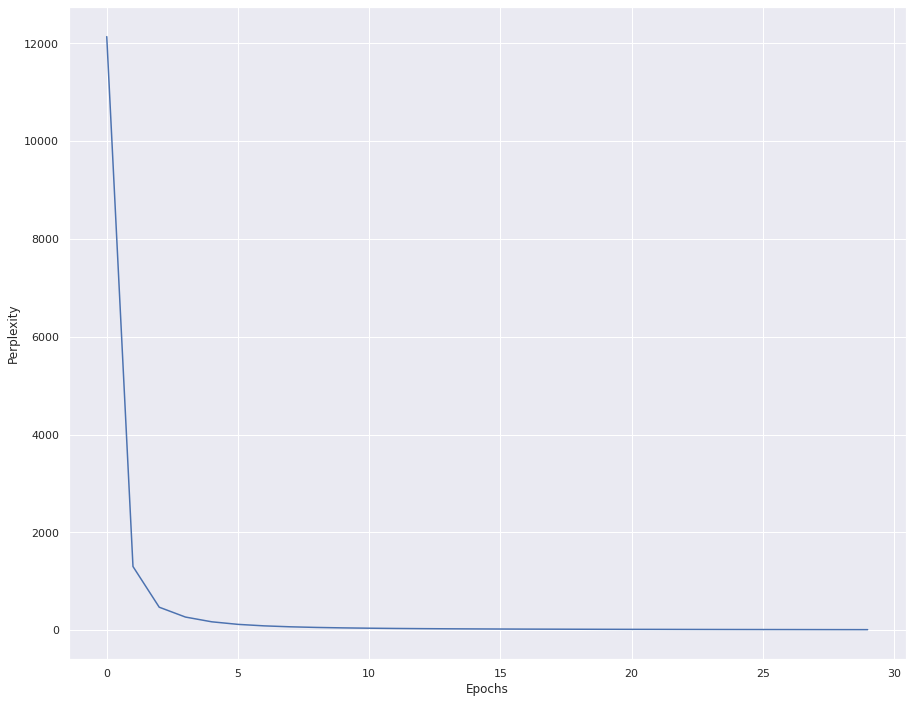

In [48]:
plt.figure(figsize=(15,12))
plt.plot(df['train_perplexity_{}'.format(model_name)])
plt.xlabel('Epochs')
plt.ylabel('Perplexity')

Text(0, 0.5, 'Perplexity')

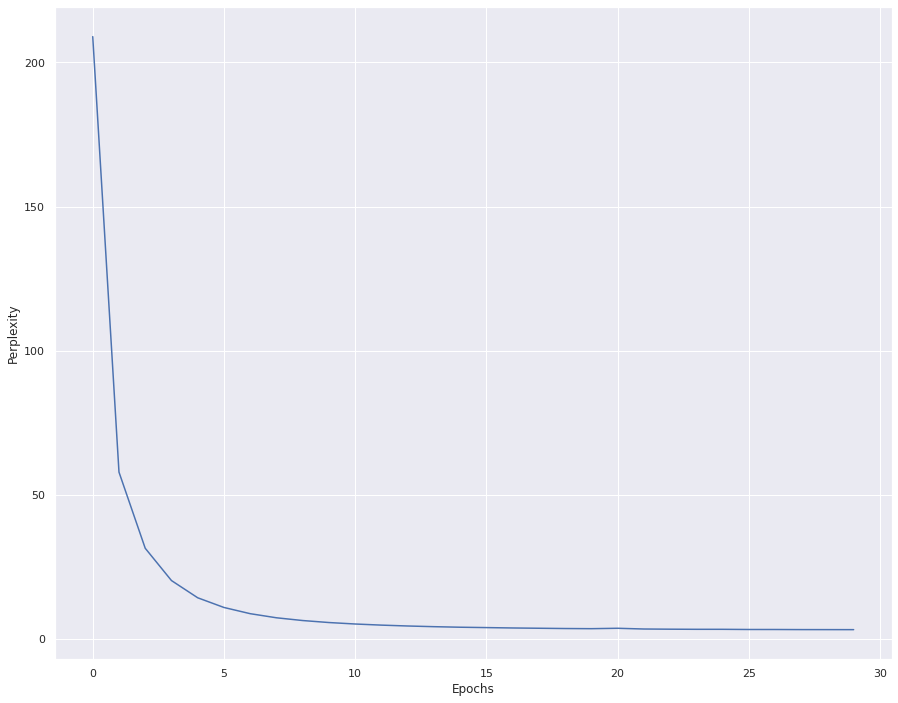

In [49]:
plt.figure(figsize=(15,12))
plt.plot(df['test_perplexity_{}'.format(model_name)])
plt.xlabel('Epochs')
plt.ylabel('Perplexity')

In [50]:
np.arange(0,max(df['train_loss_{}'.format(model_name)]),0.5)

array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5, 6. ,
       6.5, 7. , 7.5])

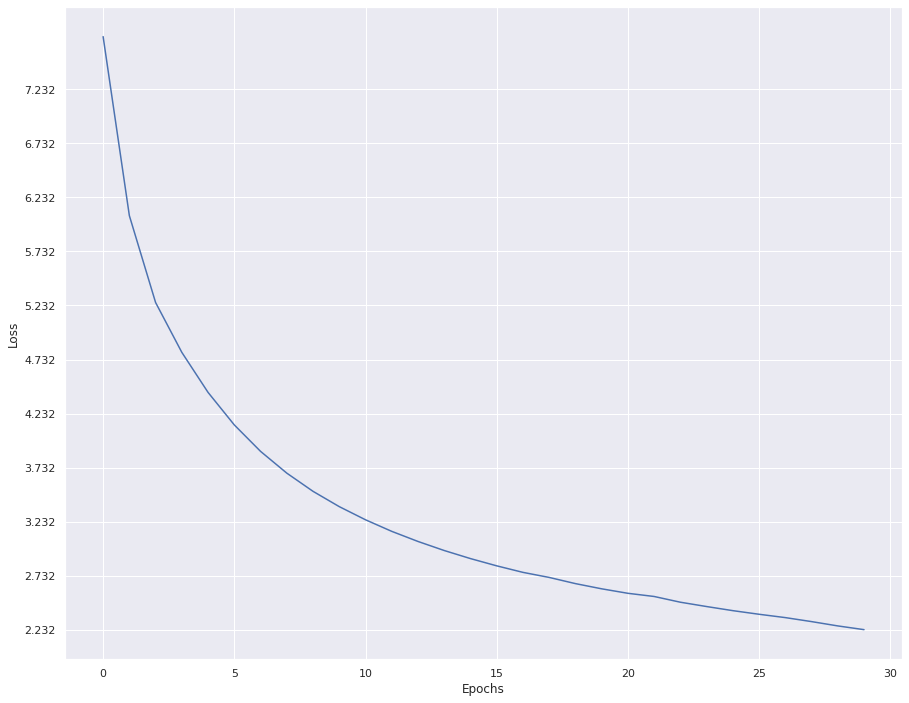

In [51]:
plt.figure(figsize=(15,12))
plt.plot(df['train_loss_{}'.format(model_name)])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yticks(np.arange(min(df['train_loss_{}'.format(model_name)]),max(df['train_loss_{}'.format(model_name)]),0.5));

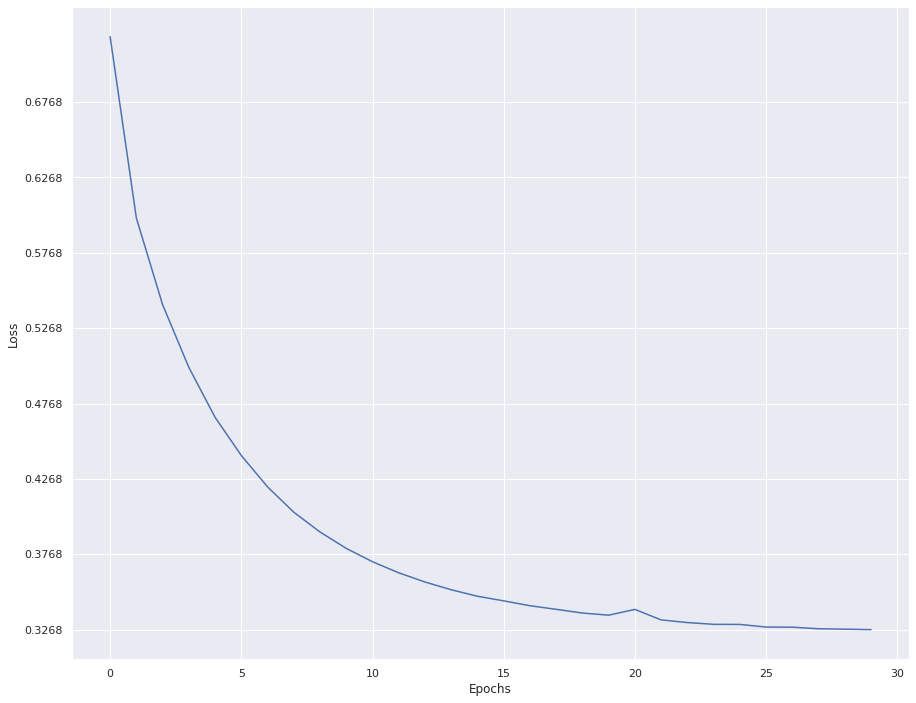

In [52]:
plt.figure(figsize=(15,12))
plt.plot(df['test_loss_{}'.format(model_name)])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yticks(np.arange(min(df['test_loss_{}'.format(model_name)]),max(df['test_loss_{}'.format(model_name)]),0.05));

# Testing model

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns

In [54]:
class Decoder:
    def __init__(self, encoder: tf.keras.Model,
                 decoder: tf.keras.Model,
                 start_token: int,
                 end_token: int,
                 max_len: int = 10, ):
        self.encoder = encoder
        self.decoder = decoder
        self.max_len = max_len
        self.start_token = start_token
        self.end_token = end_token

    def decode(self, input):
        pass


class GreedyDecoder(Decoder):
    def __init__(self, encoder: tf.keras.Model,
                 decoder: tf.keras.Model,
                 start_token: int,
                 end_token: int,
                 max_len: int = 10,
                 ):
        super().__init__(encoder,
                         decoder,
                         start_token,
                         end_token,
                         max_len
                         )

    def decode(self, input, max_len_output=50):
        initial_state = self.encoder(np.expand_dims(input, axis=0))

        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = self.start_token

        res = []
        while True:
            # Sample a token
            output, initial_state = self.decoder(target_seq,initial_state)
            sampled_token_index = np.argmax(output)

            if len(res) > max_len_output or sampled_token_index == self.end_token:
                break

            res.append(sampled_token_index)

            target_seq = np.zeros((1, 1))
            target_seq[0, 0] = sampled_token_index

       
        return res


In [55]:
class BeamSearchDecoder(Decoder):
    def __init__(self, encoder: tf.keras.Model,
                 decoder: tf.keras.Model,
                 start_token: int,
                 end_token: int,
                 max_len: int = 10,
                 ):
        super().__init__(encoder,
                         decoder,
                         start_token,
                         end_token,
                         max_len
                         )

    def decode(self, input, beam_size=3):
        start = [self.start_token]
        initial_state = self.encoder(np.expand_dims(input,axis=0))


        start_word = [[start, 0.0, initial_state]]

        while len(start_word[0][0]) < self.max_len:
            temp = []
            for s in start_word:
                target_seq = np.array([[s[0][-1]]])
                initial_state = s[-1]
                output, initial_state= self.decoder(target_seq, initial_state)
                output = np.hstack(output)
                output = tf.nn.softmax(output).numpy()
                word_preds = np.argsort(output)[-beam_size:]

                for w in word_preds:
                    next_cap, prob = s[0][:], s[1]
                    next_cap.append(w)
                    prob += output[w]
                    temp.append([next_cap, prob, initial_state])

            start_word = temp
            # Sorting according to the probabilities
            start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
            # Getting the top words
            start_word = start_word[-beam_size:]

        start_word = start_word[-1][0]

        final_caption = []

        for i in start_word:
            if i != self.end_token:
                final_caption.append(i)
            else:
                break
        return final_caption[1:]

In [56]:
def predict(data, decoder, inverse_vocab,
           beam_size=None):
    if beam_size:
        result = decoder.decode(data, beam_size=beam_size)
    else:
        result = decoder.decode(data)
    return ' '.join([inverse_vocab[i] for i in result])

In [57]:
greedy_decoder = GreedyDecoder(conv_encoder, lstm_decoder, vocab[start_token], vocab[end_token],
             max_len=39)

In [58]:
beam_decoder = BeamSearchDecoder(conv_encoder, lstm_decoder, vocab[start_token], vocab[end_token],
             max_len=39)

In [59]:
images.shape

(3840, 224, 224, 3)

In [60]:
sample = np.random.choice(range(len(images)))
sample = images[sample]

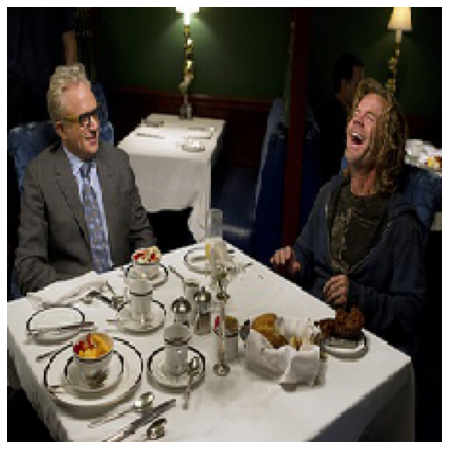

In [61]:
plt.figure(figsize=(8,8))
plt.imshow(sample)
plt.grid([])
plt.axis('off');

In [62]:
predict(sample, greedy_decoder, inverse_vocab)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



'calm calm man looks and a man'

In [63]:
predict(sample, beam_decoder, inverse_vocab, beam_size=12)

'harm happy man'

# Blue score calculation

In [64]:
from nltk.translate.bleu_score import sentence_bleu


### making predictions on test dataset with beam_size of 5

In [65]:
test_predictions = []
for batch in tqdm(test_images):
    for image in batch:
        result = predict(image, beam_decoder, inverse_vocab, beam_size=5)
        test_predictions.append(result)

100%|██████████| 6/6 [07:01<00:00, 70.18s/it]


In [66]:
test_predictions = [i.split(' ') for i in test_predictions]

In [73]:
reshaped_sequences = test_sequences.reshape(test_sequences.shape[0]*test_sequences.shape[1],-1)

In [78]:
test_sentences = []
for i in reshaped_sequences:
    tmp = []
    for word in i:
        if word!=0 and word!=1 and word!=2:
            tmp.append(inverse_vocab[word])
    test_sentences.append(tmp)

In [83]:
bleu_score = []
for reference, prediction in zip(test_sentences, test_predictions):
    bleu_score.append(sentence_bleu(reference, prediction))
print('Bleu score on test data : {}'.format(np.mean(bleu_score)))

/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
ho

Bleu score on test data : 6.660513846601549e-232


### making predictions on test dataset with beam_size of 10

In [93]:
test_predictions = []
for batch in tqdm(test_images):
    for image in batch:
        result = predict(image, beam_decoder, inverse_vocab, beam_size=10)
        test_predictions.append(result)

100%|██████████| 6/6 [13:58<00:00, 139.70s/it]


In [94]:
test_predictions = [i.split(' ') for i in test_predictions]

In [95]:
bleu_score = []
for reference, prediction in zip(test_sentences, test_predictions):
    bleu_score.append(sentence_bleu(reference, prediction))
print('Bleu score on test data : {}'.format(np.mean(bleu_score)))

Bleu score on test data : 4.368370909805482e-232
